This file originally belongs to https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial9/AE_CIFAR10.ipynb, and has been adapted to fit our needs and data

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
PATH = '/content/drive/MyDrive/Deep Learning Project/dataset'
annotations_folder_path = PATH + '/annotations/'
images_folder_path = PATH +'/images/'
CHECKPOINT_PATH = '/content/drive/MyDrive/Deep Learning Project/checkpoints'

In [ ]:
## Standard libraries
import os
import json
import math
import numpy as np

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Tensorboard extension (for visualization purposes later)
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()

## Progress bar
from tqdm.notebook import tqdm

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

<ipython-input-3-b569a8540a73>:33: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
INFO:lightning_fabric.utilities.seed:Seed set to 42


Device: cuda:0


In this tutorial, we work with the CIFAR10 dataset. In CIFAR10, each image has 3 color channels and is 32x32 pixels large. As autoencoders do not have the constrain of modeling images probabilistic, we can work on more complex image data (i.e. 3 color channels instead of black-and-white) much easier than for VAEs.
In case you have downloaded CIFAR10 already in a different directory, make sure to set DATASET_PATH accordingly to prevent another download.

In contrast to previous tutorials on CIFAR10 like [Tutorial 5](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial5/Inception_ResNet_DenseNet.html) (CNN classification), we do not normalize the data explicitly with a mean of 0 and std of 1, but roughly estimate it scaling the data between -1 and 1. This is because limiting the range will make our task of predicting/reconstructing images easier.

In [ ]:
import os
from PIL import Image
from torchvision.transforms.functional import InterpolationMode
from torch.utils.data import Subset
from torch.utils.data import DataLoader, Dataset

In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=InterpolationMode.BILINEAR),
    #transforms.CenterCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class OxfordIIITPetDataset(Dataset):
    @staticmethod
    def extract_breed(name):
        return ' '.join(name.split("_")[:-1]).lower().title()

    def __init__(self, img_dir, transform=None, transform_label=None):
        self.img_dir = img_dir
        self.image_names = [img_name for img_name in os.listdir(img_dir) if img_name.endswith('.jpg')]
        self.transform = transform
        self.transform_label = transform_label
        self.labels = list(set([self.extract_breed(name) for name in self.image_names]))
        self.labels_to_idx = {item: idx for idx, item in enumerate(self.labels)}
        self.values = {}

    def __len__(self):
        return len(self.image_names)

    def set_prediction(self, idx, value):
        self.values[idx] = value

    def get_label(self, idx):
        image_name = self.image_names[idx]
        label = self.extract_breed(image_name)
        return label

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        img_path = os.path.join(self.img_dir, image_name)
        image = Image.open(img_path).convert('RGB')
        label = self.extract_breed(image_name)
        label = self.labels_to_idx[label]
        if idx in self.values:
            label = self.values[idx]

        if self.transform:
            image = self.transform(image)
        if self.transform_label:
            label = self.transform_label(label)
        return image, label, idx

    def random_split_equal_distribution(self, split_ratios):
        assert sum(split_ratios) == 1.0, "Split ratios must sum to 1"

        label_indices = {label: [] for label in self.labels}

        # Group indices by label
        for idx in range(len(self)):
            label = self.get_label(idx)
            label_indices[label].append(idx)

        sub_indices = [[] for _ in range(len(split_ratios))]
        datasets = [None for _ in range(len(split_ratios))]

        # Shuffle indices within each label group and create subsets
        for label, indices in label_indices.items():
            np.random.shuffle(indices)
            num_samples = len(indices)
            start_idx = 0

            for i, ratio in enumerate(split_ratios):
                end_idx = start_idx + int(ratio * num_samples)
                sub_indices[i].extend(indices[start_idx:end_idx])
                start_idx = end_idx

        for i in range(len(split_ratios)):
            datasets[i] = Subset(self, sub_indices[i])

        return datasets

In [ ]:
pl.seed_everything(42)

dataset = OxfordIIITPetDataset(img_dir=images_folder_path, transform=transform)
train_set, val_set, test_set = dataset.random_split_equal_distribution([0.6, 0.2, 0.2])

train_dl = DataLoader(train_set, batch_size=100, shuffle=True, drop_last=True, num_workers=2)
val_dl = DataLoader(val_set, batch_size=100, shuffle=True, drop_last=False, num_workers=2)
test_dl = DataLoader(test_set, batch_size=100, shuffle=False, drop_last=False, num_workers=2)

def get_train_images(num):
    return torch.stack([train_set[i][0] for i in range(num)], dim=0)

INFO:lightning_fabric.utilities.seed:Seed set to 42


## Building the autoencoder

In general, an autoencoder consists of an **encoder** that maps the input $x$ to a lower-dimensional feature vector $z$, and a **decoder** that reconstructs the input $\hat{x}$ from $z$. We train the model by comparing $x$ to $\hat{x}$ and optimizing the parameters to increase the similarity between $x$ and $\hat{x}$. See below for a small illustration of the autoencoder framework.

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial9/autoencoder_visualization.svg?raw=1" style="display: block; margin-left: auto; margin-right: auto;" width="650px"/></center>

We first start by implementing the encoder. The encoder effectively consists of a deep convolutional network, where we scale down the image layer-by-layer using strided convolutions. After downscaling the image three times, we flatten the features and apply linear layers. The latent representation $z$ is therefore a vector of size *d* which can be flexibly selected.

In [ ]:
class Encoder(nn.Module):

    def __init__(self,
                 num_input_channels : int,
                 base_channel_size : int,
                 latent_dim : int,
                 act_fn : object = nn.GELU):
        """
        Inputs:
            - num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2),  # 256x256 => 128x128
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),  # 128x128 => 128x128
            act_fn(),
            nn.Conv2d(c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),  # 128x128 => 64x64
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),  # 64x64 => 64x64
            act_fn(),
            nn.Conv2d(2 * c_hid, 4 * c_hid, kernel_size=3, padding=1, stride=2),  # 64x64 => 32x32
            act_fn(),
            nn.Conv2d(4 * c_hid, 4 * c_hid, kernel_size=3, padding=1),  # 32x32 => 32x32
            act_fn(),
            nn.Conv2d(4 * c_hid, 8 * c_hid, kernel_size=3, padding=1, stride=2),  # 32x32 => 16x16
            act_fn(),
            nn.Conv2d(8 * c_hid, 8 * c_hid, kernel_size=3, padding=1),  # 16x16 => 16x16
            act_fn(),
            nn.Conv2d(8 * c_hid, 16 * c_hid, kernel_size=3, padding=1, stride=2),  # 16x16 => 8x8
            act_fn(),
            nn.Conv2d(16 * c_hid, 16 * c_hid, kernel_size=3, padding=1),  # 8x8 => 8x8
            act_fn(),
            nn.Conv2d(16 * c_hid, 32 * c_hid, kernel_size=3, padding=1, stride=2),  # 8x8 => 4x4
            act_fn(),
            nn.Conv2d(32 * c_hid, 32 * c_hid, kernel_size=3, padding=1),  # 4x4 => 4x4
            act_fn(),
            nn.Flatten(),  # Image grid to single feature vector
            nn.Linear(4 * 4 * 32 * c_hid, latent_dim)  # Adjusted for 4x4 spatial dimensions
        )

    def forward(self, x):
        return self.net(x)

Note that we do not apply Batch Normalization here. This is because we want the encoding of each image to be independent of all the other images. Otherwise, we might introduce correlations into the encoding or decoding that we do not want to have. In some implementations, you still can see Batch Normalization being used, because it can also serve as a form of regularization. Nevertheless, the better practice is to go with other normalization techniques if necessary like Instance Normalization or Layer Normalization. Given the small size of the model, we can neglect normalization for now.

The decoder is a mirrored, flipped version of the encoder. The only difference is that we replace strided convolutions by transposed convolutions (i.e. deconvolutions) to upscale the features. Transposed convolutions can be imagined as adding the stride to the input instead of the output, and can thus upscale the input. For an illustration of a `nn.ConvTranspose2d` layer with kernel size 3, stride 2, and padding 1, see below (figure credit - [Vincent Dumoulin and Francesco Visin](https://arxiv.org/abs/1603.07285)):

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial9/deconvolution.gif?raw=1" width="250px"></center>

You see that for an input of size $3\times3$, we obtain an output of $5\times5$. However, to truly have a reverse operation of the convolution, we need to ensure that the layer scales the input shape by a factor of 2 (e.g. $4\times4\to8\times8$). For this, we can specify the parameter `output_padding` which adds additional values to the output shape. Note that we do not perform zero-padding with this, but rather increase the output shape for calculation.

Overall, the decoder can be implemented as follows:

In [ ]:
class Decoder(nn.Module):

    def __init__(self,
                 num_input_channels: int,
                 base_channel_size: int,
                 latent_dim: int,
                 act_fn=nn.GELU):
        """
        Inputs:
            - num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 4 * 4 * 32 * c_hid),  # Adjusted linear layer output size
            act_fn()
        )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(32 * c_hid, 16 * c_hid, kernel_size=4, stride=2, padding=1),  # 4x4 => 8x8
            act_fn(),
            nn.Conv2d(16 * c_hid, 16 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(16 * c_hid, 8 * c_hid, kernel_size=4, stride=2, padding=1),  # 8x8 => 16x16
            act_fn(),
            nn.Conv2d(8 * c_hid, 8 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(8 * c_hid, 4 * c_hid, kernel_size=4, stride=2, padding=1),  # 16x16 => 32x32
            act_fn(),
            nn.Conv2d(4 * c_hid, 4 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(4 * c_hid, 2 * c_hid, kernel_size=4, stride=2, padding=1),  # 32x32 => 64x64
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2 * c_hid, c_hid, kernel_size=4, stride=2, padding=1),  # 64x64 => 128x128
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(c_hid, num_input_channels, kernel_size=4, stride=2, padding=1),  # 128x128 => 256x256

            nn.Tanh()  # The input images are scaled between -1 and 1, hence the output has to be bounded as well
        )

    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.net(x)
        return x


The encoder and decoder networks we chose here are relatively simple. Usually, more complex networks are applied, especially when using a ResNet-based architecture. For example, see [VQ-VAE](https://arxiv.org/abs/1711.00937) and [NVAE](https://arxiv.org/abs/2007.03898) (although the papers discuss architectures for VAEs, they can equally be applied to standard autoencoders).

In a final step, we add the encoder and decoder together into the autoencoder architecture. We define the autoencoder as PyTorch Lightning Module to simplify the needed training code:

In [ ]:
class Autoencoder(pl.LightningModule):

    def __init__(self,
                 base_channel_size: int,
                 latent_dim: int,
                 encoder_class : object = Encoder,
                 decoder_class : object = Decoder,
                 num_input_channels: int = 3,
                 width: int = 256,
                 height: int = 256):
        super().__init__()
        # Saving hyperparameters of autoencoder
        self.save_hyperparameters()
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim)
        # Example input array needed for visualizing the graph of the network
        self.example_input_array = torch.zeros(2, num_input_channels, width, height)

    def forward(self, x):
        """
        The forward function takes in an image and returns the reconstructed image
        """
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

    def _get_reconstruction_loss(self, batch):
        """
        Given a batch of images, this function returns the reconstruction loss (MSE in our case)
        """
        x = batch[0] # We do not need the labels
        x_hat = self.forward(x)
        loss = F.mse_loss(x, x_hat, reduction="none")
        loss = loss.sum(dim=[1,2,3]).mean(dim=[0])
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        # Using a scheduler is optional but can be helpful.
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                         mode='min',
                                                         factor=0.2,
                                                         patience=20,
                                                         min_lr=5e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

    def training_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('test_loss', loss)

For the loss function, we use the mean squared error (MSE). The mean squared error pushes the network to pay special attention to those pixel values its estimate is far away. Predicting 127 instead of 128 is not important when reconstructing, but confusing 0 with 128 is much worse. Note that in contrast to VAEs, we do not predict the probability per pixel value, but instead use a distance measure. This saves a lot of parameters and simplifies training. To get a better intuition per pixel, we report the summed squared error averaged over the batch dimension (any other mean/sum leads to the same result/parameters).

However, MSE has also some considerable disadvantages. Usually, MSE leads to blurry images where small noise/high-frequent patterns are removed as those cause a very low error. To ensure realistic images to be reconstructed, one could combine Generative Adversarial Networks (lecture 10) with autoencoders as done in several works (e.g. see [here](https://arxiv.org/abs/1704.02304), [here](https://arxiv.org/abs/1511.05644) or these [slides](http://elarosca.net/slides/iccv_autoencoder_gans.pdf)). Additionally, comparing two images using MSE does not necessarily reflect their visual similarity. For instance, suppose the autoencoder reconstructs an image shifted by one pixel to the right and bottom. Although the images are almost identical, we can get a higher loss than predicting a constant pixel value for half of the image (see code below). An example solution for this issue includes using a separate, pre-trained CNN, and use a distance of visual features in lower layers as a distance measure instead of the original pixel-level comparison.

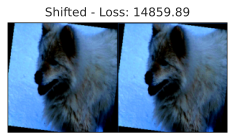

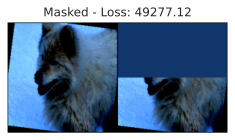

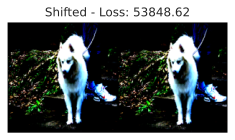

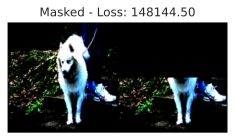

In [ ]:
def compare_imgs(img1, img2, title_prefix=""):
    # Calculate MSE loss between both images
    loss = F.mse_loss(img1, img2, reduction="sum")
    # Plot images for visual comparison
    grid = torchvision.utils.make_grid(torch.stack([img1, img2], dim=0), nrow=2)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(4,2))
    plt.title(f"{title_prefix} Loss: {loss.item():4.2f}")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

for i in range(2):
    # Load example image
    img, _, _ = train_set[i]
    img_mean = img.mean(dim=[1,2], keepdims=True)

    # Shift image by one pixel
    SHIFT = 1
    img_shifted = torch.roll(img, shifts=SHIFT, dims=1)
    img_shifted = torch.roll(img_shifted, shifts=SHIFT, dims=2)
    img_shifted[:,:1,:] = img_mean
    img_shifted[:,:,:1] = img_mean
    compare_imgs(img, img_shifted, "Shifted -")

    # Set half of the image to zero
    img_masked = img.clone()
    img_masked[:,:img_masked.shape[1]//2,:] = img_mean
    compare_imgs(img, img_masked, "Masked -")

### Training the model

During the training, we want to keep track of the learning progress by seeing reconstructions made by our model. For this, we implement a callback object in PyTorch Lightning which will add reconstructions every $N$ epochs to our tensorboard:

In [ ]:
class GenerateCallback(pl.Callback):

    def __init__(self, input_imgs, every_n_epochs=1):
        super().__init__()
        self.input_imgs = input_imgs # Images to reconstruct during training
        self.every_n_epochs = every_n_epochs # Only save those images every N epochs (otherwise tensorboard gets quite large)

    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.every_n_epochs == 0:
            # Reconstruct images
            input_imgs = self.input_imgs.to(pl_module.device)
            with torch.no_grad():
                pl_module.eval()
                reconst_imgs = pl_module(input_imgs)
                pl_module.train()
            # Plot and add to tensorboard
            imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
            grid = torchvision.utils.make_grid(imgs, nrow=2)
            trainer.logger.experiment.add_image("Reconstructions", grid, global_step=trainer.global_step)

We will now write a training function that allows us to train the autoencoder with different latent dimensionality and returns both the test and validation score. We provide pre-trained models and recommend you using those, especially when you work on a computer without GPU. Of course, feel free to train your own models on Snellius.

In [ ]:
## TODO: CHECK IF WE CAN RETRAIN FROM A CHECKPOINT!

def train_cifar(latent_dim):
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, f"cifar10_{latent_dim}"),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=5,
                         log_every_n_steps=10,
                         callbacks=[ModelCheckpoint(save_weights_only=True),
                                    GenerateCallback(get_train_images(8), every_n_epochs=10),
                                    LearningRateMonitor("epoch")])
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    #pretrained_filename = os.path.join(CHECKPOINT_PATH, f"cifar10_{latent_dim}.ckpt")
    #if os.path.isfile(pretrained_filename):
    #    print("Found pretrained model, loading...")
    #    model = Autoencoder.load_from_checkpoint(pretrained_filename)
    #else:
    model = Autoencoder(base_channel_size=32, latent_dim=latent_dim)
    trainer.fit(model, train_dl, val_dl)
    # Test best model on validation and test set
    val_result = trainer.test(model, val_dl, verbose=False)
    test_result = trainer.test(model, test_dl, verbose=False)
    result = {"test": test_result, "val": val_result}
    return model, result

### Comparing latent dimensionality

When training an autoencoder, we need to choose a dimensionality for the latent representation $z$. The higher the latent dimensionality, the better we expect the reconstruction to be. However, the idea of autoencoders is to *compress* data. Hence, we are also interested in keeping the dimensionality low. To find the best tradeoff, we can train multiple models with different latent dimensionalities. The original input has $32\times 32\times 3 = 3072$ pixels. Keeping this in mind, a reasonable choice for the latent dimensionality might be between 64 and 384:

In [ ]:
model_dict = {}
for latent_dim in [64, 128, 256, 384]:
    model_ld, result_ld = train_cifar(latent_dim)
    model_dict[latent_dim] = {"model": model_ld, "result": result_ld}

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params | In sizes         | Out sizes       
--------------------------------------------------------------------------
0 | encoder | Encoder | 19.9 M | [2, 3, 256, 256] | [2, 64]         
1 | decoder | Decoder | 15.4 M | [2, 64]          | [2, 3, 256, 256]
--------------------------------------------------------------------------
35.3 M    Trainable params
0         Non-trainable params
35.3 M    Total params
141.215   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params | In sizes         | Out sizes       
--------------------------------------------------------------------------
0 | encoder | Encoder | 21.0 M | [2, 3, 256, 256] | [2, 128]        
1 | decoder | Decoder | 16.4 M | [2, 128]         | [2, 3, 256, 256]
--------------------------------------------------------------------------
37.4 M    Trainable params
0         Non-trainable params
37.4 M    Total params
149.604   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params | In sizes         | Out sizes       
--------------------------------------------------------------------------
0 | encoder | Encoder | 23.1 M | [2, 3, 256, 256] | [2, 256]        
1 | decoder | Decoder | 18.5 M | [2, 256]         | [2, 3, 256, 256]
--------------------------------------------------------------------------
41.6 M    Trainable params
0         Non-trainable params
41.6 M    Total params
166.381   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params | In sizes         | Out sizes       
--------------------------------------------------------------------------
0 | encoder | Encoder | 25.2 M | [2, 3, 256, 256] | [2, 384]        
1 | decoder | Decoder | 20.6 M | [2, 384]         | [2, 3, 256, 256]
--------------------------------------------------------------------------
45.8 M    Trainable params
0         Non-trainable params
45.8 M    Total params
183.159   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

After training the models, we can plot the reconstruction loss over the latent dimensionality to get an intuition how these two properties are correlated:

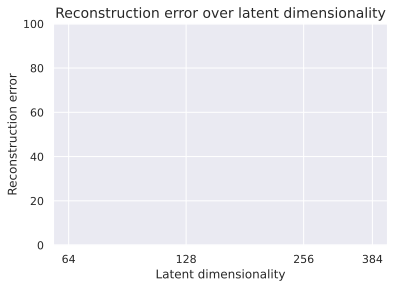

In [ ]:
latent_dims = sorted([k for k in model_dict])
val_scores = [model_dict[k]["result"]["val"][0]["test_loss"] for k in latent_dims]

fig = plt.figure(figsize=(6,4))
plt.plot(latent_dims, val_scores, '--', color="#000", marker="*", markeredgecolor="#000", markerfacecolor="y", markersize=16)
plt.xscale("log")
plt.xticks(latent_dims, labels=latent_dims)
plt.title("Reconstruction error over latent dimensionality", fontsize=14)
plt.xlabel("Latent dimensionality")
plt.ylabel("Reconstruction error")
plt.minorticks_off()
plt.ylim(0,100)
plt.show()

As we initially expected, the reconstruction loss goes down with increasing latent dimensionality. For our model and setup, the two properties seem to be exponentially (or double exponentially) correlated. To understand what these differences in reconstruction error mean, we can visualize example reconstructions of the four models. For simplicity, we visualize four training images of CIFAR10 we have seen already before. For larger models that may overfit, it is recommended to use images from the validation set.

In [ ]:
def visualize_reconstructions(model, input_imgs):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs = model(input_imgs.to(model.device))
    reconst_imgs = reconst_imgs.cpu()

    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(7,4.5))
    plt.title(f"Reconstructed from {model.hparams.latent_dim} latents")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

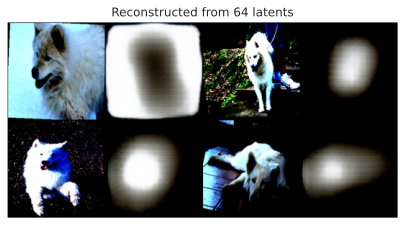

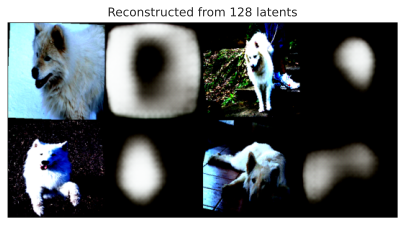

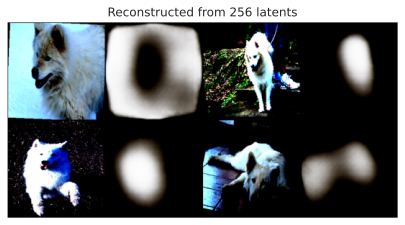

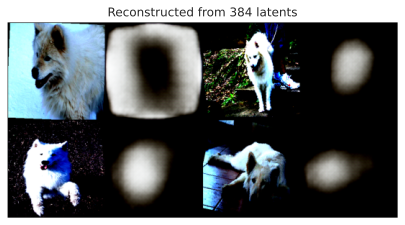

In [ ]:
input_imgs = get_train_images(4)
for latent_dim in model_dict:
    visualize_reconstructions(model_dict[latent_dim]["model"], input_imgs)

Clearly, the smallest latent dimensionality can only save information about the rough shape and color of the object, but the reconstructed image is extremely blurry and it is hard to recognize the original object in the reconstruction. With 128 features, we can recognize some shapes again although the picture remains blurry. The models with the highest two dimensionalities reconstruct the images quite well. The difference between 256 and 384 is marginal at first sight but can be noticed when comparing, for instance, the backgrounds of the first image (the 384 features model more of the pattern than 256).

### Out-of-distribution images

Before continuing with the applications of autoencoder, we can actually explore some limitations of our autoencoder. For example, what happens if we try to reconstruct an image that is clearly out of the distribution of our dataset? We expect the decoder to have learned some common patterns in the dataset, and thus might in particular fail to reconstruct images that do not follow these patterns.

The first experiment we can try is to reconstruct noise. We, therefore, create two images whose pixels are randomly sampled from a uniform distribution over pixel values, and visualize the reconstruction of the model (feel free to test different latent dimensionalities):

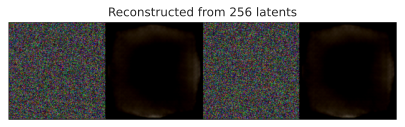

In [ ]:
rand_imgs = torch.rand(2, 3, 256, 256) * 2 - 1
visualize_reconstructions(model_dict[256]["model"], rand_imgs)

The reconstruction of the noise is quite poor, and seems to introduce some rough patterns. As the input does not follow the patterns of the CIFAR dataset, the model has issues reconstructing it accurately.

We can also check how well the model can reconstruct other manually-coded patterns:

/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


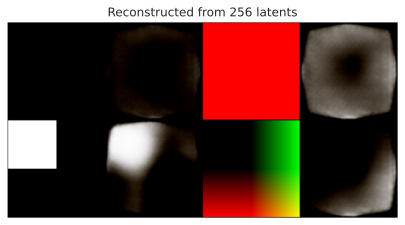

In [ ]:
plain_imgs = torch.zeros(4, 3, 256, 256)

# Single color channel
plain_imgs[1,0] = 1
# Checkboard pattern
plain_imgs[2,:,:128,:128] = 1
plain_imgs[2,:,128:,128:] = -1
# Color progression
xx, yy = torch.meshgrid(torch.linspace(-1,1,256), torch.linspace(-1,1,256))
plain_imgs[3,0,:,:] = xx
plain_imgs[3,1,:,:] = yy

visualize_reconstructions(model_dict[256]["model"], plain_imgs)

The plain, constant images are reconstructed relatively good although the single color channel contains some noticeable noise. The hard borders of the checkboard pattern are not as sharp as intended, as well as the color progression, both because such patterns never occur in the real-world pictures of CIFAR.

In general, autoencoders tend to fail reconstructing high-frequent noise (i.e. sudden, big changes across few pixels) due to the choice of MSE as loss function (see our previous discussion about loss functions in autoencoders). Small misalignments in the decoder can lead to huge losses so that the model settles for the expected value/mean in these regions. For low-frequent noise, a misalignment of a few pixels does not result in a big difference to the original image. However, the larger the latent dimensionality becomes, the more of this high-frequent noise can be accurately reconstructed.

### Generating new images

Variational autoencoders are a generative version of the autoencoders because we regularize the latent space to follow a Gaussian distribution. However, in vanilla autoencoders, we do not have any restrictions on the latent vector. So what happens if we would actually input a randomly sampled latent vector into the decoder? Let's find it out below:

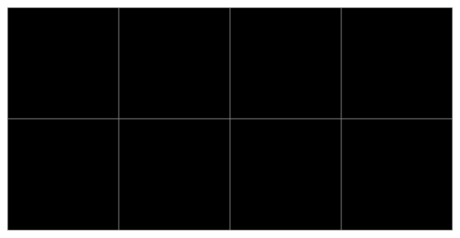

In [ ]:
model = model_dict[256]["model"]
latent_vectors = torch.randn(8, model.hparams.latent_dim, device=model.device)
with torch.no_grad():
    imgs = model.decoder(latent_vectors)
    imgs = imgs.cpu()

grid = torchvision.utils.make_grid(imgs, nrow=4, pad_value=0.5)
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(8,5))
plt.imshow(grid)
plt.axis('off')
plt.show()

As we can see, the generated images more look like art than realistic images. As the autoencoder was allowed to structure the latent space in whichever way it suits the reconstruction best, there is no incentive to map every possible latent vector to realistic images. Furthermore, the distribution in latent space is unknown to us and doesn't necessarily follow a multivariate normal distribution. Thus, we can conclude that vanilla autoencoders are indeed not generative.

## Finding visually similar images

One application of autoencoders is to build an image-based search engine to retrieve visually similar images. This can be done by representing all images as their latent dimensionality, and find the closest $K$ images in this domain. The first step to such a search engine is to encode all images into $z$. In the following, we will use the training set as a search corpus, and the test set as queries to the system.

<span style="color: #880000">(Warning: the following cells can be computationally heavy for a weak CPU-only system. If you do not have a strong computer and are not on Google Colab, you might want to skip the execution of the following cells and rely on the results shown in the filled notebook)</span>

In [ ]:
# We use the following model throughout this section.
# If you want to try a different latent dimensionality, change it here!
model = model_dict[128]["model"]

In [ ]:
def embed_imgs(model, data_loader):
    # Encode all images in the data_laoder using model, and return both images and encodings
    img_list, embed_list = [], []
    model.eval()
    for imgs, _, _ in tqdm(data_loader, desc="Encoding images", leave=False):
        with torch.no_grad():
            z = model.encoder(imgs.to(model.device))
        img_list.append(imgs)
        embed_list.append(z)
    return (torch.cat(img_list, dim=0), torch.cat(embed_list, dim=0))

train_img_embeds = embed_imgs(model, train_dl)
test_img_embeds = embed_imgs(model, test_dl)


Encoding images:   0%|          | 0/44 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


After encoding all images, we just need to write a function that finds the closest $K$ images and returns (or plots) those:

In [ ]:
def find_similar_images(query_img, query_z, key_embeds, K=8):
    # Find closest K images. We use the euclidean distance here but other like cosine distance can also be used.
    dist = torch.cdist(query_z[None,:], key_embeds[1], p=2)
    dist = dist.squeeze(dim=0)
    dist, indices = torch.sort(dist)
    # Plot K closest images
    imgs_to_display = torch.cat([query_img[None], key_embeds[0][indices[:K]]], dim=0)
    grid = torchvision.utils.make_grid(imgs_to_display, nrow=K+1)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(12,3))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

In [ ]:
# Plot the closest images for the first N test images as example
for i in range(8):
    find_similar_images(test_img_embeds[0][i], test_img_embeds[1][i], key_embeds=train_img_embeds)

Based on our autoencoder, we see that we are able to retrieve many similar images to the test input. In particular, in row 4, we can spot that some test images might not be that different from the training set as we thought (same poster, just different scaling/color scaling). We also see that although we haven't given the model any labels, it can cluster different classes in different parts of the latent space (airplane + ship, animals, etc.). This is why autoencoders can also be used as a pre-training strategy for deep networks, especially when we have a large set of unlabeled images (often the case). However, it should be noted that the background still plays a big role in autoencoders while it doesn't for classification. Hence, we don't get "perfect" clusters and need to finetune such models for classification.

### Tensorboard clustering

Another way of exploring the similarity of images in the latent space is by dimensionality-reduction methods like PCA or T-SNE. Luckily, Tensorboard provides a nice interface for this and we can make use of it in the following:

In [ ]:
# We use the following model throughout this section.
# If you want to try a different latent dimensionality, change it here!
model = model_dict[128]["model"]

In [ ]:
# Create a summary writer
writer = SummaryWriter("tensorboard/")

The function `add_embedding` allows us to add high-dimensional feature vectors to TensorBoard on which we can perform clustering. What we have to provide in the function are the feature vectors, additional metadata such as the labels, and the original images so that we can identify a specific image in the clustering.

In [ ]:
## In case you obtain the following error in the next cell, execute the import statements and last line in this cell
##   AttributeError: module 'tensorflow._api.v2.io.gfile' has no attribute 'get_filesystem'

# import tensorflow as tf
# import tensorboard as tb
# tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [ ]:
# Note: the embedding projector in tensorboard is computationally heavy.
# Reduce the image amount below if your computer struggles with visualizing all 10k points
NUM_IMGS = len(test_set)

writer.add_embedding(test_img_embeds[1][:NUM_IMGS], # Encodings per image
                     metadata=[test_set[i][1] for i in range(NUM_IMGS)], # Adding the labels per image to the plot
                     label_img=(test_img_embeds[0][:NUM_IMGS]+1)/2.0) # Adding the original images to the plot

Finally, we can run tensorboard to explore similarities among images:

In [ ]:
%tensorboard --logdir tensorboard/

You should be able to see something similar as in the following image. In case the projector stays empty, try to start the TensorBoard outside of the Jupyter notebook.

<center><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial9/tensorboard_projector_screenshot.jpeg?raw=1" width="70%"/></center>

Overall, we can see that the model indeed clustered images together that are visually similar. Especially the background color seems to be a crucial factor in the encoding. This correlates to the chosen loss function, here Mean Squared Error on pixel-level because the background is responsible for more than half of the pixels in an average image. Hence, the model learns to focus on it. Nevertheless, we can see that the encodings also separate a couple of classes in the latent space although it hasn't seen any labels. This shows again that autoencoding can also be used as a "pre-training"/transfer learning task before classification.

In [ ]:
# Closing the summary writer
writer.close()